| Columna       | Descripción                                                                                       |
|---------------|---------------------------------------------------------------------------------------------------|
| id            | Identificador único de cada paciente.                                                             |
| age           | Edad del paciente expresada en días.                                                              |
| gender        | Género (1 = mujer, 2 = hombre).                                                                   |
| height        | Estatura del paciente en centímetros.                                                             |
| weight        | Peso del paciente en kilogramos.                                                                  |
| ap_hi         | Presión arterial sistólica (cuando el corazón late), medida en mmHg.                              |
| ap_lo         | Presión arterial diastólica (cuando el corazón está en reposo), en mmHg.                          |
| cholesterol   | Nivel de colesterol: 1 = normal, 2 = por encima de lo normal, 3 = muy por encima de lo normal.   |
| gluc          | Nivel de glucosa: 1 = normal, 2 = por encima de lo normal, 3 = muy por encima de lo normal.      |
| smoke         | Indica si la persona fuma (0 = no, 1 = sí).                                                       |
| alco          | Indica si la persona consume alcohol (0 = no, 1 = sí).                                            |
| active        | Indica si la persona realiza actividad física (0 = no, 1 = sí).                                   |
| cardio        | Variable objetivo: presencia de enfermedad cardiovascular (0 = no, 1 = sí).                       |


In [21]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.sql import functions as F
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import ChiSquareTest
from pyspark.sql import Row

#Inicialización pyspark
spark = SparkSession.builder \
    .appName("CardioSparkModel") \
    .getOrCreate()


In [22]:
 
#Importar dataset a Spark 

df_spark = spark.read.csv("cardio_train.csv", header=True, inferSchema=True, sep=";")
df_spark.show()

+---+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+
| id|  age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|
+---+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+
|  0|18393|     2|   168|  62.0|  110|   80|          1|   1|    0|   0|     1|     0|
|  1|20228|     1|   156|  85.0|  140|   90|          3|   1|    0|   0|     1|     1|
|  2|18857|     1|   165|  64.0|  130|   70|          3|   1|    0|   0|     0|     1|
|  3|17623|     2|   169|  82.0|  150|  100|          1|   1|    0|   0|     1|     1|
|  4|17474|     1|   156|  56.0|  100|   60|          1|   1|    0|   0|     0|     0|
|  8|21914|     1|   151|  67.0|  120|   80|          2|   2|    0|   0|     0|     0|
|  9|22113|     1|   157|  93.0|  130|   80|          3|   1|    0|   0|     1|     0|
| 12|22584|     2|   178|  95.0|  130|   90|          3|   3|    0|   0|     1|     1|
| 13|17668|     1|   158|  71.0|  110|   70

In [23]:
df_spark.printSchema()

root
 |-- id: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- height: integer (nullable = true)
 |-- weight: double (nullable = true)
 |-- ap_hi: integer (nullable = true)
 |-- ap_lo: integer (nullable = true)
 |-- cholesterol: integer (nullable = true)
 |-- gluc: integer (nullable = true)
 |-- smoke: integer (nullable = true)
 |-- alco: integer (nullable = true)
 |-- active: integer (nullable = true)
 |-- cardio: integer (nullable = true)



### Fórmula del Índice de Masa Corporal (BMI)

$
BMI = \frac{\text{peso (kg)}}{(\text{estatura (m)})^2}
$

In [24]:
# Creación de columna Edad y Masa corporal.
df_spark = df_spark.withColumn("age_years", col("age")/365) # Calculo de Edad

# Calculo de Masa Corporal Se dicide entre 100 por que la estatura en el data set esta en Cm
df_spark = df_spark.withColumn("bmi", col("weight") / ((col("height")/100)**2))

df_spark.show()

+---+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+------------------+------------------+
| id|  age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|         age_years|               bmi|
+---+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+------------------+------------------+
|  0|18393|     2|   168|  62.0|  110|   80|          1|   1|    0|   0|     1|     0|50.391780821917806|  21.9671201814059|
|  1|20228|     1|   156|  85.0|  140|   90|          3|   1|    0|   0|     1|     1| 55.41917808219178|34.927679158448385|
|  2|18857|     1|   165|  64.0|  130|   70|          3|   1|    0|   0|     0|     1| 51.66301369863014|23.507805325987146|
|  3|17623|     2|   169|  82.0|  150|  100|          1|   1|    0|   0|     1|     1| 48.28219178082192| 28.71047932495361|
|  4|17474|     1|   156|  56.0|  100|   60|          1|   1|    0|   0|     0|     0| 47.87397260273973|23.011176857330703|


StringIndexer sirve para convertir variables categóricas en números, porque los modelos de Machine Learning solo trabajan con variables numéricas.

En el dataset:

cholesterol tiene valores: 1, 2, 3

gluc tiene valores: 1, 2, 3

Aunque parezcan números, no representan cantidades, sino categorías.

Ejemplo:
No es cierto que "3 de colesterol" sea tres veces más colesterol que "1".
Son solo niveles de riesgo, no valores continuos.

➡ Por eso se convierten a índices internos:

categoría 1 → índice 0.0

categoría 2 → índice 1.0

categoría 3 → índice 2.0

In [25]:
#StringIndexer toma una columna que contiene categorías 
# (texto o números que representan clases) y las convierte 
# en índices numéricos para que los modelos de Machine Learning de PySpark las puedan usar.

indexer_chol = StringIndexer(inputCol="cholesterol", outputCol="cholesterol_idx")
indexer_gluc = StringIndexer(inputCol="gluc", outputCol="gluc_idx")

df_spark = indexer_chol.fit(df_spark).transform(df_spark)
df_spark = indexer_gluc.fit(df_spark).transform(df_spark)

df_spark.show()

+---+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+------------------+------------------+---------------+--------+
| id|  age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|         age_years|               bmi|cholesterol_idx|gluc_idx|
+---+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+------------------+------------------+---------------+--------+
|  0|18393|     2|   168|  62.0|  110|   80|          1|   1|    0|   0|     1|     0|50.391780821917806|  21.9671201814059|            0.0|     0.0|
|  1|20228|     1|   156|  85.0|  140|   90|          3|   1|    0|   0|     1|     1| 55.41917808219178|34.927679158448385|            2.0|     0.0|
|  2|18857|     1|   165|  64.0|  130|   70|          3|   1|    0|   0|     0|     1| 51.66301369863014|23.507805325987146|            2.0|     0.0|
|  3|17623|     2|   169|  82.0|  150|  100|          1|   1|    0|   0|     1|     1| 48.2821917808

In [26]:


# Variable objetivo
target = "cardio"

# Variables a evaluar
features = ["age", "ap_hi", "ap_lo", "cholesterol", "gluc",
            "smoke", "alco", "active", "bmi"]

# Nivel de significancia
alpha = 0.05

# Ensamblar características
assembler = VectorAssembler(
    inputCols=features,
    outputCol="features"
)

df_vector = assembler.transform(df_spark).select("features", target)

# Ejecutar prueba Chi-cuadrada
chi = ChiSquareTest.test(df_vector, "features", target).head()

# Resultados
p_values = chi.pValues
chi_values = chi.statistics

print("\nResultados de la Prueba Chi-cuadrada\n")
print("H₀: La variable es independiente de 'cardio'")
print("H₁: La variable está asociada con 'cardio'\n")

# Crear lista con resultados
rows = []
for i, col_name in enumerate(features):
    decision = "Rechazar H₀" if p_values[i] < alpha else "No rechazar H₀"

    rows.append({
        "Variable": col_name,
        "Chi2": float(chi_values[i]),
        "p_value": float(p_values[i]),
        "Decision": decision
    })

# Convertir directamente a Pandas (más estable)
results_df = pd.DataFrame(rows)

# Mostrar tabla bonita
results_df



Resultados de la Prueba Chi-cuadrada

H₀: La variable es independiente de 'cardio'
H₁: La variable está asociada con 'cardio'



,Variable,Chi2,p_value,Decision
0,age,11785.151387,0.000000,Rechazar H₀
1,ap_hi,15504.388541,0.000000,Rechazar H₀
2,ap_lo,9946.536552,0.000000,Rechazar H₀
3,cholesterol,3423.438898,0.000000,Rechazar H₀
4,gluc,586.911809,0.000000,Rechazar H₀
5,smoke,16.786994,0.000042,Rechazar H₀
6,alco,3.761261,0.052453,No rechazar H₀
7,active,88.980787,0.000000,Rechazar H₀
8,bmi,6391.626639,0.000000,Rechazar H₀


In [27]:
from pyspark.sql.functions import mean, stddev

columna = "cholesterol"

stats = df_spark.select(
    mean(columna).alias("media"),
    stddev(columna).alias("std")
).collect()[0]

media = stats["media"]
std = stats["std"]

print("Media:", media)
print("Desviación estándar:", std)


Media: 1.3668714285714285
Desviación estándar: 0.6802503486993823


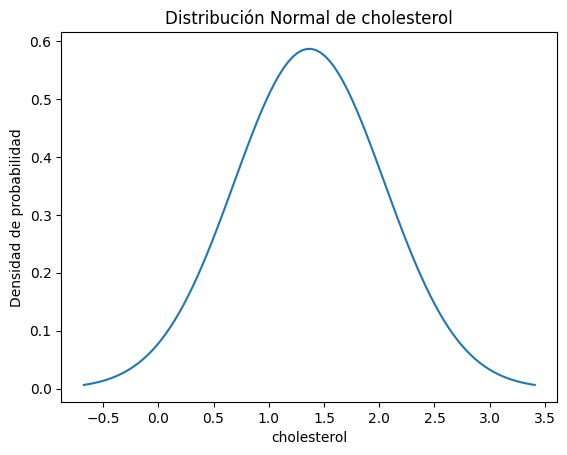

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Rango de valores
x = np.linspace(media - 3*std, media + 3*std, 100)

# Curva normal
y = norm.pdf(x, media, std)

plt.figure()
plt.plot(x, y)
plt.title("Distribución Normal de cholesterol")
plt.xlabel("cholesterol")
plt.ylabel("Densidad de probabilidad")
plt.show()


Valor Z: 0.9307287716045921


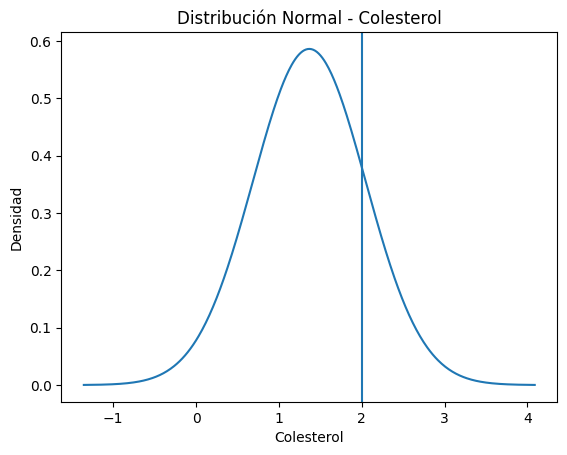

In [34]:

# Cambia el valor de x
x = 2

# Calcular z
z = (x - media) / std

print("Valor Z:", z)

# Convertir Z a valor real de X
x_z = media + z * std

# Crear rango de valores
x = np.linspace(media - 4*std, media + 4*std, 500)
y = norm.pdf(x, media, std)

# Graficar la curva normal
plt.plot(x, y)
plt.axvline(x_z)  # Línea para el valor Z

# Títulos
plt.title("Distribución Normal - Colesterol")
plt.xlabel("Colesterol")
plt.ylabel("Densidad")

plt.show()

Valor Z: 0.9307287716045921


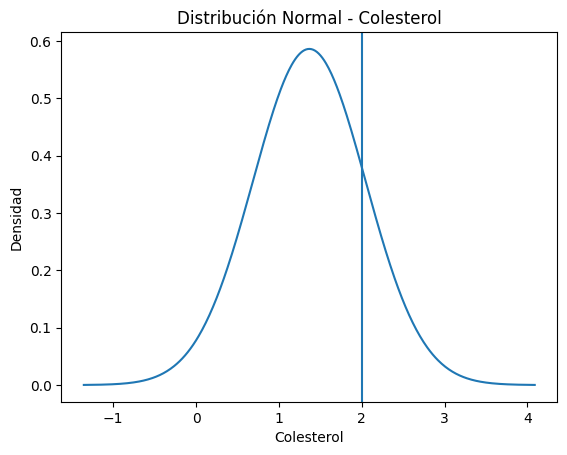

In [ ]:

# Cambia el valor de x
x = 2

# Calcular z
z = (x - media) / std

print("Valor Z:", z)

# Convertir Z a valor real de X
x_z = media + z * std

# Crear rango de valores
x = np.linspace(media - 4*std, media + 4*std, 500)
y = norm.pdf(x, media, std)

# Graficar la curva normal
plt.plot(x, y)
plt.axvline(x_z)  # Línea para el valor Z

# Títulos
plt.title("Distribución Normal - Colesterol")
plt.xlabel("Colesterol")
plt.ylabel("Densidad")

plt.show()

In [30]:


# Seleccionar columnas necesarias
df_model = df_spark.select("cholesterol", "cardio")

# Crear vector de características
assembler = VectorAssembler(
    inputCols=["cholesterol"],
    outputCol="features"
)

data = assembler.transform(df_model)

# Crear y entrenar el modelo
lr = LogisticRegression(
    featuresCol="features",
    labelCol="cardio"
)

model = lr.fit(data)

# Mostrar coeficientes
print("Coeficiente:", model.coefficients)
print("Intercepto:", model.intercept)


Coeficiente: [0.6980840636508187]
Intercepto: -0.9422909378044806


+-----+-----+-----+-----------+
|  age|ap_hi|ap_lo|cholesterol|
+-----+-----+-----+-----------+
|18393|  110|   80|          1|
|20228|  140|   90|          3|
|18857|  130|   70|          3|
|17623|  150|  100|          1|
|17474|  100|   60|          1|
+-----+-----+-----+-----------+
only showing top 5 rows

                  age     ap_hi     ap_lo  cholesterol
age          1.000000  0.020764  0.017647     0.154424
ap_hi        0.020764  1.000000  0.016086     0.023778
ap_lo        0.017647  0.016086  1.000000     0.024019
cholesterol  0.154424  0.023778  0.024019     1.000000


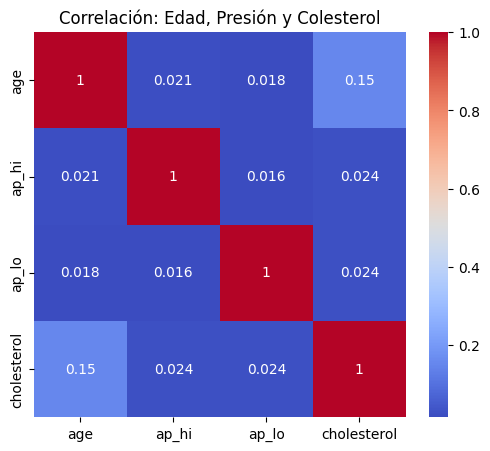

In [32]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import seaborn as sns

# Seleccionar las columnas
df_sub = df_spark.select(
    col("age"),
    col("ap_hi"),
    col("ap_lo"),
    col("cholesterol")
)

# Mostrar datos
df_sub.show(5)

# Convertir a pandas
df_pandas = df_sub.toPandas()

# Matriz de correlación
matriz_corr = df_pandas.corr()
print(matriz_corr)

# Graficar mapa de calor
plt.figure(figsize=(6,5))
sns.heatmap(matriz_corr, annot=True, cmap='coolwarm')
plt.title("Correlación: Edad, Presión y Colesterol")
plt.show()



In [46]:
# Definir que columnas se requiere unir para crear un solo vector
assembler = VectorAssembler(
    inputCols=[
        "age_years","bmi","ap_hi","ap_lo","cholesterol_idx","gluc_idx",
        "smoke","alco","active"
    ],
    outputCol="features"
)

data = assembler.transform(df_spark).select("features", "cardio")

In [48]:
#dividir el data set
train, test = data.randomSplit([0.7, 0.3], seed=42)

In [49]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator



lr = LogisticRegression(labelCol="cardio", featuresCol="features")

modelo_spark = lr.fit(train)

pred = modelo_spark.transform(test)



In [50]:
evaluator = BinaryClassificationEvaluator(
    labelCol="cardio", rawPredictionCol="rawPrediction", metricName="areaUnderROC"
)

auc = evaluator.evaluate(pred)
print("AUC:", auc)

AUC: 0.7839138193011427


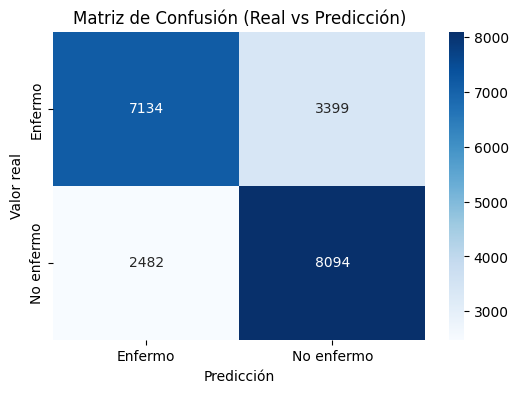

In [51]:


# 1. Matriz de confusión en PySpark

conf = (
    pred
    .groupBy("cardio", "prediction")
    .count()
    .orderBy("cardio", "prediction")
)

# Convertir a Pandas
conf_pd = conf.toPandas()


# Convertir a Pandas
conf_pd = conf.toPandas()


# 2. Reemplazar 0/1 por etiquetas

label_map = {0: "No enfermo", 1: "Enfermo"}

conf_pd["cardio"] = conf_pd["cardio"].map(label_map)
conf_pd["prediction"] = conf_pd["prediction"].map(label_map)

# Crear matriz pivote
conf_matrix = conf_pd.pivot(index="cardio", columns="prediction", values="count")
conf_matrix = conf_matrix.fillna(0)


# 3. Gráfica Heatmap

plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="g", cmap="Blues")

plt.title("Matriz de Confusión (Real vs Predicción)")
plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.show()